# STEREO/SECCHI-EUVI

In [ ]:
ds_path = "./data/stereo/euvi"

start_date = "2011-01-01"
end_date = "2011-01-02"

## explore

In [ ]:
from pathlib import Path

wavelengths = [171, 195, 284, 304]
dirs = [str(wl) for wl in wavelengths]

[(Path(ds_path) / "a" / wl).mkdir(parents=True, exist_ok=True) for wl in dirs]
[(Path(ds_path) / "b" / wl).mkdir(parents=True, exist_ok=True) for wl in dirs]

[None, None, None, None]

In [ ]:
from datetime import datetime, timedelta

t_start = datetime.strptime(start_date, "%Y-%m-%d")
t_end = datetime.strptime(end_date, "%Y-%m-%d")
td = timedelta(hours=12)
date_list = [t_start + i * td for i in range((t_end - t_start) // td)]

In [ ]:
d = date_list[0]

In [ ]:
d

datetime.datetime(2011, 1, 1, 0, 0)

In [ ]:
root = "https://stereo-ssc.nascom.nasa.gov/data/ins_data/secchi/L0_YMD/"

In [ ]:
root_a = root + "a/img/euvi/"
root_b = root + "b/img/euvi/"

In [ ]:
date = datetime.strftime(d, "%Y/%m/%d/")
date

'2011/01/01/'

In [ ]:
stereo_a_url = root_a + date
stereo_b_url = root_b + date

In [ ]:
stereo_a_url

'https://stereo-ssc.nascom.nasa.gov/data/ins_data/secchi/L0_YMD/a/img/euvi/2011/01/01/'

In [ ]:
stereo_b_url

'https://stereo-ssc.nascom.nasa.gov/data/ins_data/secchi/L0_YMD/b/img/euvi/2011/01/01/'

In [ ]:
from urllib.request import urlopen
from urllib.error import HTTPError, URLError
from bs4 import BeautifulSoup

def get_bs(url):
    try:
        html = urlopen(url)
    except HTTPError as e:
        print(e)
    except URLError as e:
        print("The server could not be found!")
    else:
        bs = BeautifulSoup(html.read(), 'html.parser')
        return bs

In [ ]:
bs = get_bs(stereo_a_url)

In [ ]:
link_list = bs.find_all('a')

In [ ]:
len(link_list)

606

In [ ]:
link_list[:10]

[<a href="?C=N;O=D">Name</a>,
 <a href="?C=M;O=A">Last modified</a>,
 <a href="?C=S;O=A">Size</a>,
 <a href="/data/ins_data/secchi/L0_YMD/a/img/euvi/2011/01/">Parent Directory</a>,
 <a href="20110101_000530_n4euA.fts">20110101_000530_n4euA.fts</a>,
 <a href="20110101_000615_n4euA.fts">20110101_000615_n4euA.fts</a>,
 <a href="20110101_001030_n4euA.fts">20110101_001030_n4euA.fts</a>,
 <a href="20110101_001400_n4euA.fts">20110101_001400_n4euA.fts</a>,
 <a href="20110101_001530_n4euA.fts">20110101_001530_n4euA.fts</a>,
 <a href="20110101_001615_n4euA.fts">20110101_001615_n4euA.fts</a>]

In [ ]:
import re
fts_re = re.compile(datetime.strftime(d, "%Y%m%d") + ".*.fts")

fts_list = bs.find_all('a', {'href': fts_re})

In [ ]:
len(fts_list)

602

In [ ]:
f = fts_list[0]
f

<a href="20110101_000530_n4euA.fts">20110101_000530_n4euA.fts</a>

In [ ]:
for i, f in enumerate(fts_list):
    obstime = datetime.strptime(f.get('href')[:15], "%Y%m%d_%H%M%S")
    if obstime.hour != d.hour:
        break

In [ ]:
def get_idx(fts_list, date):
    # find the first index of the fts file that has the same hour as the date
    for i, f in enumerate(fts_list):
        obstime = datetime.strptime(f.get('href')[:15], "%Y%m%d_%H%M%S")
        if obstime.hour == date.hour:
            return i

In [ ]:
i = get_idx(fts_list, d)
fts_list[i]

<a href="20110101_000530_n4euA.fts">20110101_000530_n4euA.fts</a>

In [ ]:
dd = date_list[1]
print(dd)
i = get_idx(fts_list, dd)
fts_list[i]

2011-01-01 12:00:00


<a href="20110101_120030_n4euA.fts">20110101_120030_n4euA.fts</a>

In [ ]:
from astropy.io import fits

In [ ]:
# Create url list until all possible wavelengths are found.
data = []
possible_values = {171, 195, 284, 304}
seen_values = set()

idx = get_idx(fts_list, dd)
for f in fts_list[idx:]:
    url = stereo_a_url + f.get('href')
    # hdul = fits.open(url)
    # header = hdul[0].header
    # hdul.close()
    header = fits.getheader(url)
    if header['NAXIS1'] < 2048 or header['NAXIS2'] < 2048 or header['NMISSING'] != 0:
        print("Invalid file:", f.get('href'))
        continue

    info = {}
    info['obstime'] = datetime.strptime(f.get('href')[:15], "%Y%m%d_%H%M%S")
    info['wavelength'] = header['WAVELNTH']
    info['source'] = "a"
    info['url'] = url
    data.append(info)

    seen_values.add(int(header['WAVELNTH']))
    if seen_values == possible_values:
        break

In [ ]:
len(data)

8

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(data)
df

,obstime,wavelength,source,url
0,2011-01-01 12:00:30,195,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
1,2011-01-01 12:05:30,195,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
2,2011-01-01 12:06:15,304,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
3,2011-01-01 12:10:30,195,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
4,2011-01-01 12:14:00,171,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
5,2011-01-01 12:15:30,195,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
6,2011-01-01 12:16:15,304,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
7,2011-01-01 12:16:30,284,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...


In [ ]:
df_171 = df[df['wavelength'] == 171].sort_values(by='obstime').reset_index(drop=True)
df_195 = df[df['wavelength'] == 195].sort_values(by='obstime').reset_index(drop=True)
df_284 = df[df['wavelength'] == 284].sort_values(by='obstime').reset_index(drop=True)
df_304 = df[df['wavelength'] == 304].sort_values(by='obstime').reset_index(drop=True)

In [ ]:
df_171

,obstime,wavelength,source,url
0,2011-01-01 12:14:00,171,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...


In [ ]:
df_195

,obstime,wavelength,source,url
0,2011-01-01 12:00:30,195,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
1,2011-01-01 12:05:30,195,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
2,2011-01-01 12:10:30,195,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
3,2011-01-01 12:15:30,195,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...


In [ ]:
df_284

,obstime,wavelength,source,url
0,2011-01-01 12:16:30,284,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...


In [ ]:
df_304

,obstime,wavelength,source,url
0,2011-01-01 12:06:15,304,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...
1,2011-01-01 12:16:15,304,a,https://stereo-ssc.nascom.nasa.gov/data/ins_da...


In [ ]:
sample = df_171.iloc[0]
sample.obstime

Timestamp('2011-01-01 12:14:00')

In [ ]:
def round_hour(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
            + timedelta(hours=t.minute // 30))

In [ ]:
round_hour(sample.obstime)

Timestamp('2011-01-01 12:00:00')

In [ ]:
Path(ds_path) / sample.source / str(sample.wavelength)

PosixPath('data/stereo/euvi/a/171')

## downloader

In [ ]:
from datetime import datetime, timedelta

t_start = datetime.strptime(start_date, "%Y-%m-%d")
t_end = datetime.strptime(end_date, "%Y-%m-%d")
td = timedelta(hours=12)
date_list = [t_start + i * td for i in range((t_end - t_start) // td)]

In [ ]:
from itipy.download.download_stereo_secchi_euvi import STEREOEUVIDownloader

downloader = STEREOEUVIDownloader(ds_path=ds_path)

In [ ]:
for d in date_list:
    downloader.downloadDate(d)

2025-02-13 21:20:15,351 - STEREOEUVIDownloader - INFO - Start download: 2011-01-01T00:00:00
A 171: 100%|██████████| 8.02M/8.02M [00:04<00:00, 2.07MB/s]
A 284: 100%|██████████| 8.02M/8.02M [00:04<00:00, 1.69MB/s]
A 195: 100%|██████████| 8.02M/8.02M [00:06<00:00, 1.29MB/s]
B 171: 100%|██████████| 8.02M/8.02M [00:03<00:00, 2.71MB/s]
A 304: 100%|██████████| 8.02M/8.02M [00:10<00:00, 830kB/s]]
B 304: 100%|██████████| 8.02M/8.02M [00:03<00:00, 2.65MB/s]
B 284: 100%|██████████| 8.02M/8.02M [00:07<00:00, 1.14MB/s]
B 195: 100%|██████████| 8.02M/8.02M [00:12<00:00, 661kB/s] 
2025-02-13 21:21:21,257 - STEREOEUVIDownloader - INFO - Finished: 2011-01-01T00:00:00
2025-02-13 21:21:21,258 - STEREOEUVIDownloader - INFO - Start download: 2011-01-01T12:00:00
2025-02-13 21:21:32,451 - STEREOEUVIDownloader - INFO - Invalid file (B): 20110101_120530_n7euB.fts
A 171: 100%|██████████| 8.02M/8.02M [00:03<00:00, 2.65MB/s]
A 284: 100%|██████████| 8.02M/8.02M [00:03<00:00, 2.22MB/s]
A 195: 100%|██████████| 8.02M/

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


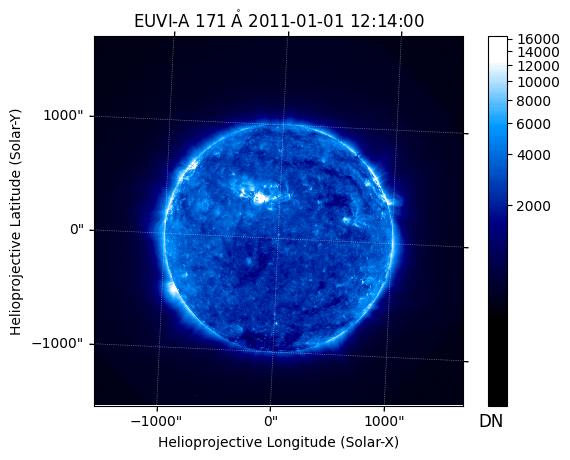

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


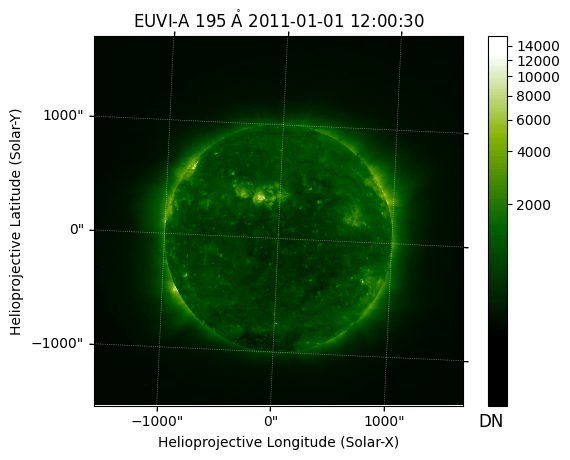

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


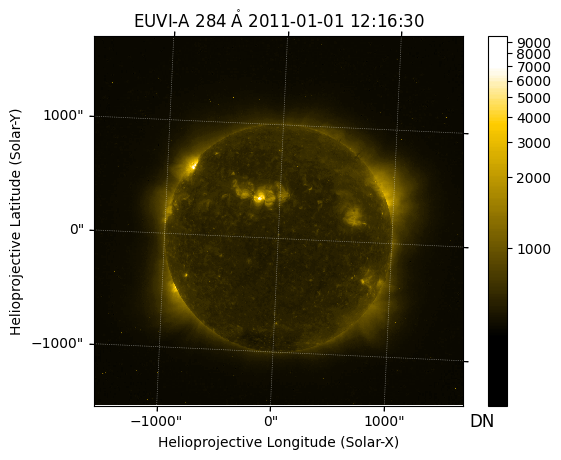

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


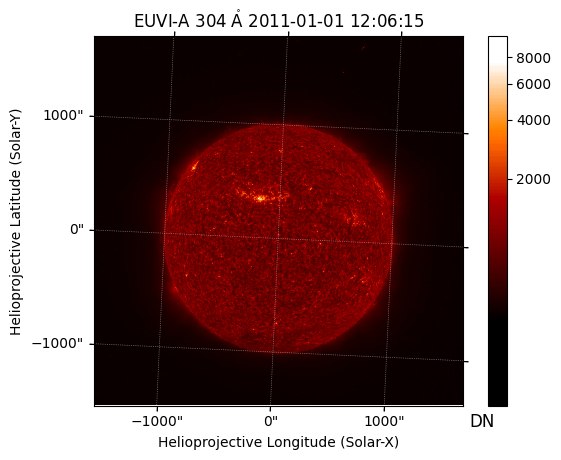

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


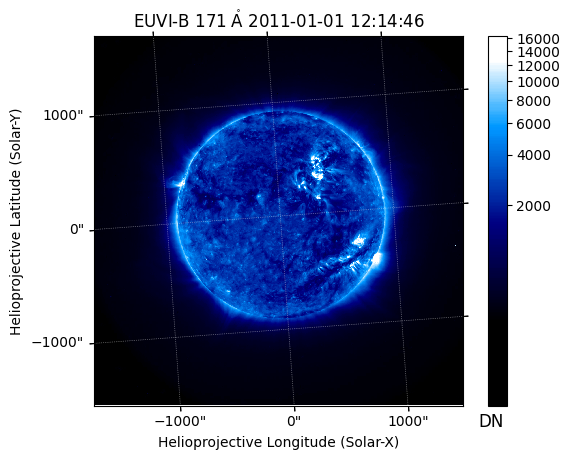

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


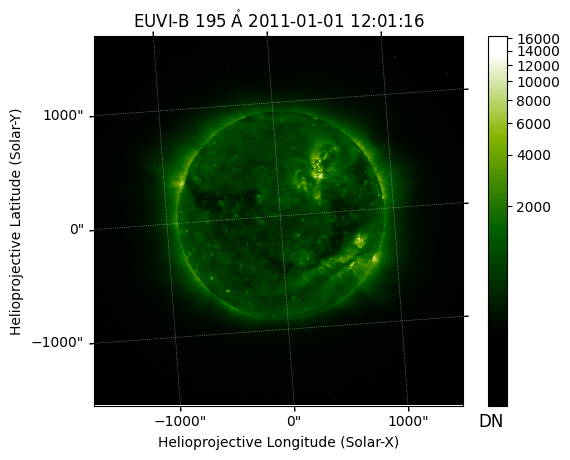

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


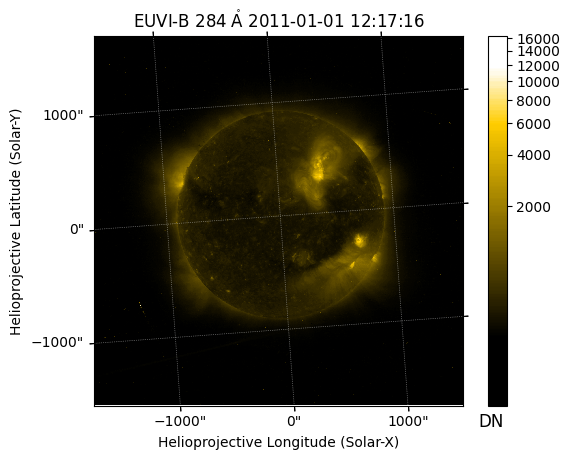

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


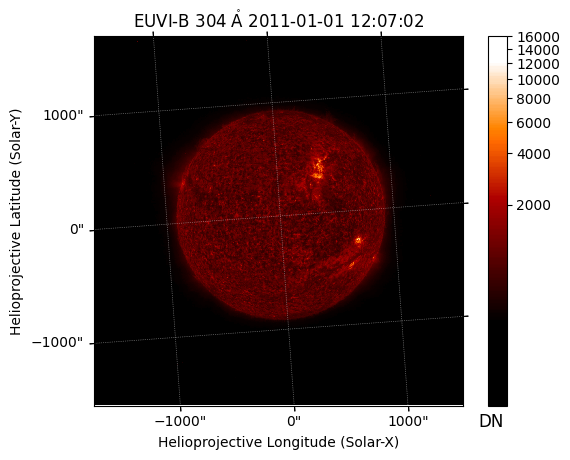

In [ ]:
from pathlib import Path
from sunpy.map import Map

dl = Path(ds_path)

for src in ["a", "b"]:
    for wl in downloader.wavelengths:
        file = dl / src / str(wl) / f"{start_date}T120000.fits"
        smap = Map(file)
        smap.peek()

In [ ]:
from pathlib import Path
from itipy.download.util import download_url

url_invalid = "https://stereo-ssc.nascom.nasa.gov/data/ins_data/secchi/L0_YMD/b/img/euvi/2011/01/01/20110101_120530_n7euB.fts"
file_invalid = "20110101_120530_n7euB.fts"

if not Path(file_invalid).exists():
    download_url(url_invalid, filename=file_invalid)

map_invalid = Map(file_invalid)

20110101_120530_n7euB.fts: 100%|██████████| 536k/536k [00:01<00:00, 300kB/s]  


In [ ]:
map_valid = Map("data/stereo/euvi/b/195/2011-01-01T120000.fits")

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


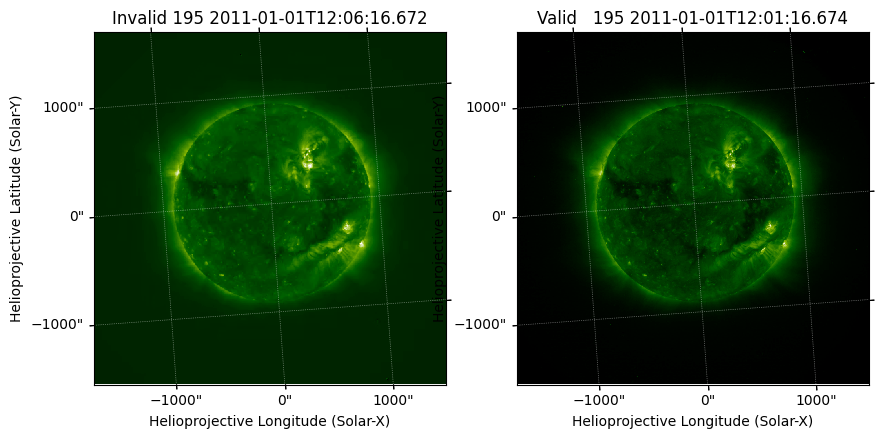

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121, projection=map_invalid)
map_invalid.plot(axes=ax1)
ax1.set_title(f"Invalid {map_invalid.meta['wavelnth']} {map_invalid.meta['date-obs']}")
ax2 = fig.add_subplot(122, projection=map_valid)
map_valid.plot(axes=ax2)
ax2.set_title(f"Valid   {map_valid.meta['wavelnth']} {map_valid.meta['date-obs']}")
plt.show()

In [ ]:
print("Invalid")
print("NAXIS1", map_invalid.meta['naxis1'])
print("NAXIS2", map_invalid.meta['naxis2'])
print("NMISSING", map_invalid.meta['nmissing'])
print()
print("Valid")
print("NAXIS1", map_valid.meta['naxis1'])
print("NAXIS2", map_valid.meta['naxis2'])
print("NMISSING", map_valid.meta['nmissing'])

Invalid
NAXIS1 512
NAXIS2 512
NMISSING 0

Valid
NAXIS1 2048
NAXIS2 2048
NMISSING 0
